In [1]:
import torch
from matplotlib import pyplot as plt
import torch.optim as optim
import numpy as np

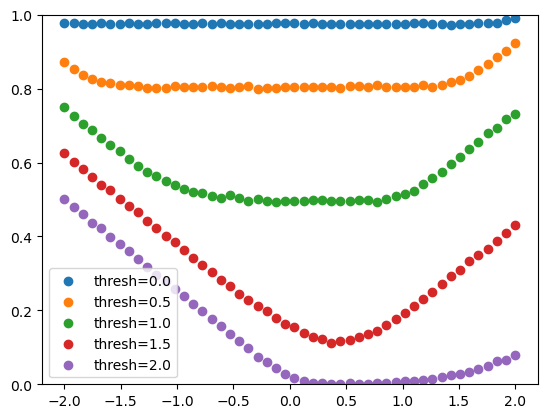

In [32]:
# Define Noisy Objective Function
def expensive_function(x):
    """The 1st column of x gives the nominal inputs, 2nd column gives the input noise"""
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    # Add some additional noise we want to capture via Bayesian layers
    std = 0.2
    mu = torch.zeros(x.shape[0])
    extra_noise = torch.normal(mean=mu, std=std)
    return noised_value + extra_noise

# Define computation of 'true' robustness measure by brute force sampling
def robust_measures(x_design, robustness_thresh, eps=2, num_eps_samples=100, num_repeats=100):
    robust_measures = torch.empty((x_design.shape[0], 1))
    for i, x_d in enumerate(x_design):
        x = torch.empty((num_eps_samples, 2))
        x[:,0] = x_d.repeat(num_eps_samples)
        x[:,1] = torch.linspace(-eps, eps, num_eps_samples)
        x = x.repeat((num_repeats,1))
        robust_measure = torch.sum(expensive_function(x) > robustness_thresh) / len(x)
        robust_measures[i] = robust_measure
    return robust_measures

EPS = 2
x_design = torch.linspace(-EPS, EPS, 50)

# Check out robustness measure at different thresholds
for robustness_thresh in torch.linspace(0,2,5):
    true_robust_measures = robust_measures(x_design, robustness_thresh=robustness_thresh, 
                                           eps=EPS, num_eps_samples=100, num_repeats=100)
    
    plt.scatter(x_design, true_robust_measures, label=f'thresh={torch.round(robustness_thresh, decimals=2)}')
    plt.ylim(0, 1);
    plt.legend()

# Use threshold with a clear minimum for testing
ROBUSTNESS_THRESH = 1.5
true_robust_measures = robust_measures(x_design, robustness_thresh=ROBUSTNESS_THRESH, 
                                       eps=EPS, num_eps_samples=500, num_repeats=500)

# Generate training data for NN
NUM_TRAIN = 500
NUM_TRAIN_REPEATS = 1
train_x = torch.empty(NUM_TRAIN, 2)
train_x[:,0].uniform_(-2,2)
train_x[:,1].uniform_(-EPS, EPS)
train_x = train_x.repeat((NUM_TRAIN_REPEATS,1)) # Generate repeats of the initial points to help learn variance
train_y  = expensive_function(train_x)

In [33]:
models = {}
num_models = 2
for model_i in range(num_models):
    if model_i == 0:
        from NN_deterministic import *
        # SAMPLE_NBR = 3
        NUM_EPOCHS = 6_000
        PENALTY_WEIGHT = 1e-12
        COMPLEXITY_COST_WEIGHT = None
        models.update({str(model_i): {}})
        models[str(model_i)]['label'] = 'deterministic NN'
    elif model_i == 1:
        from NN_bayesian import *
        # SAMPLE_NBR = 6
        NUM_EPOCHS = 3_000
        PENALTY_WEIGHT = None
        COMPLEXITY_COST_WEIGHT = 1e-6
        models.update({str(model_i): {}})
        models[str(model_i)]['label'] = 'bayesian NN'
    SAMPLE_NBR = 1
    # NUM_EPOCHS = 3000
    HIDDEN_DIM = 50

    model = NN(input_dim=train_x.shape[1], hidden_dim = HIDDEN_DIM)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"training model {models[str(model_i)]['label']}")
    for epoch in range(NUM_EPOCHS):
        optimizer.zero_grad()
        loss = loss_fn(model, train_x, train_y, sample_nbr=SAMPLE_NBR, 
                       complexity_cost_weight=COMPLEXITY_COST_WEIGHT,
                       penalty_weight=PENALTY_WEIGHT)
        loss.backward()
        optimizer.step()
        if epoch % (int(NUM_EPOCHS/10)) == 0:
            print(f"Epoch {epoch}: ELBO Loss = {loss.item():.4f}")
    models[str(model_i)]['trained_model'] = model

training model deterministic NN
Epoch 0: ELBO Loss = 146.5198
Epoch 600: ELBO Loss = 0.3643
Epoch 1200: ELBO Loss = 0.0318
Epoch 1800: ELBO Loss = -0.0615
Epoch 2400: ELBO Loss = -0.1370
Epoch 3000: ELBO Loss = -0.1901
Epoch 3600: ELBO Loss = -0.2203
Epoch 4200: ELBO Loss = -0.2360
Epoch 4800: ELBO Loss = -0.2450
Epoch 5400: ELBO Loss = -0.2563
training model bayesian NN
Epoch 0: ELBO Loss = 1.8345
Epoch 300: ELBO Loss = 0.1055
Epoch 600: ELBO Loss = 0.0843
Epoch 900: ELBO Loss = 0.0774
Epoch 1200: ELBO Loss = 0.0701
Epoch 1500: ELBO Loss = 0.0681
Epoch 1800: ELBO Loss = 0.0600
Epoch 2100: ELBO Loss = 0.0572
Epoch 2400: ELBO Loss = 0.0552
Epoch 2700: ELBO Loss = 0.0534


Text(0, 0.5, 'MSE on robust measure')

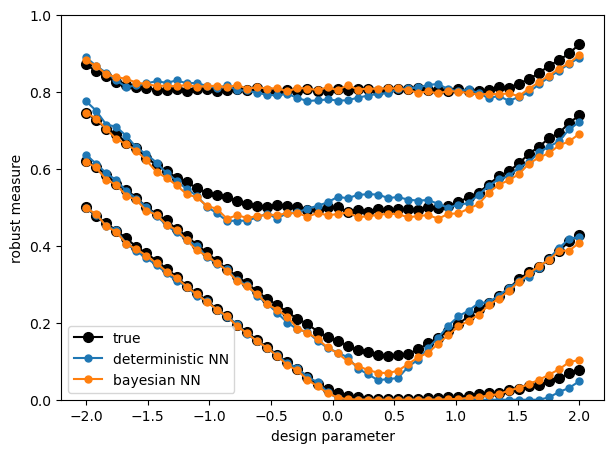

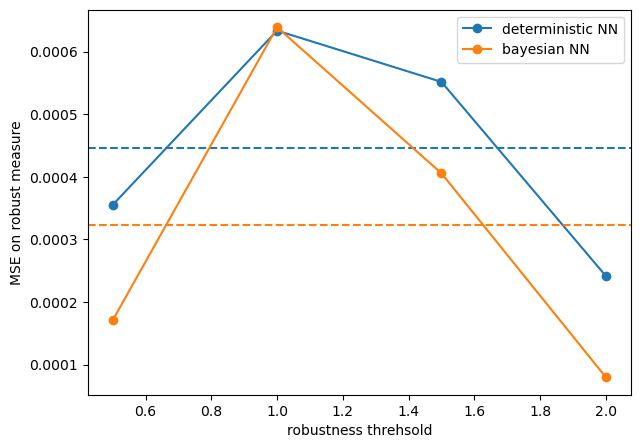

In [34]:
# Initialize a place to store MSE results
for model_i in range(num_models):
    models[str(model_i)]['all_mse'] = []

robustness_thresholds = torch.linspace(0.5,2,4)
fig, ax = plt.subplots(1, figsize=(7,5))
ax.set_ylim(0,1)
ax.set_ylabel('robust measure')
ax.set_xlabel('design parameter')
for thresh_i, robustness_thresh in enumerate(robustness_thresholds):
    true_robust_measures = robust_measures(x_design, robustness_thresh=robustness_thresh, 
                                           eps=EPS, num_eps_samples=100, num_repeats=100)
    ax.plot(x_design, true_robust_measures, marker='o', c='k', markersize=7, label=('true' if thresh_i==0 else '_'))

    for model_i in range(num_models):
        model = models[str(model_i)]['trained_model']
        model_label = models[str(model_i)]['label'] if thresh_i==0 else '_'
        model_robust_measures = model.posterior_robust(x_design, robustness_thresh, num_eps_samples=10_000, eps=EPS)
        mse = torch.square(torch.abs(model_robust_measures - true_robust_measures)).mean()
        models[str(model_i)]['all_mse'].append(mse)

        ax.plot(x_design, model_robust_measures, marker='o', markersize=5, 
                 label=f"{model_label}", color=f'C{model_i}')
        ax.legend()

fig, ax = plt.subplots(1, figsize=(7,5))
for model_i in range(num_models):
    ax.plot(robustness_thresholds, models[str(model_i)]['all_mse'], label=models[str(model_i)]['label'], 
            marker='o', color=f'C{model_i}')
    ax.axhline(np.mean(models[str(model_i)]['all_mse']), ls='--', color=f'C{model_i}')
ax.legend()
ax.set_xlabel('robustness threhsold')
ax.set_ylabel('MSE on robust measure')

- Relative accuracy can change significantly between training data sets, but not between retraining on same training set
- For no extra noise
    - Bayesian MSE seems more consistent wrt to retraining (on same training data) than Deterministic. Sometimes Deterministic spikes. 
    - Increase in model accuracy significantly diminishes above ~60 training points. 
    - Increasing complexity cost weight on Bayesian degrades accuracy. Decreasing no effect.
    - Changing penalty weight on Deterministic has no effect
- Overtraining (too many epochs) seems like an issue with Deterministic, not so much with Bayesian

In [35]:
test_x = torch.empty((50,2))
test_x[:,0].uniform_(-EPS,EPS)
test_x[:,1].uniform_(-EPS,EPS)

true_means = torch.empty(len(test_x))
true_stds = torch.empty(len(test_x))

for model_i in range(num_models):
    models[str(model_i)].update({'test_means': torch.empty(len(test_x))})
    models[str(model_i)].update({'test_stds': torch.empty(len(test_x))})

with torch.no_grad():
    for x_i, x in enumerate(test_x):
        x_repeats = x.repeat((100,1))
        
        test_y = expensive_function(x_repeats)
        true_means[x_i] = torch.mean(test_y)
        true_stds[x_i] = torch.std(test_y)
        
        for model_i in range(num_models):
            model = models[str(model_i)]['trained_model']
            if 'bayesian' in models[str(model_i)]['label']:
                preds, _ = model(x_repeats)
                # preds = torch.stack([model(x)[0] for _ in range(100)])
                models[str(model_i)]['test_means'][x_i] = torch.mean(preds)
                models[str(model_i)]['test_stds'][x_i] = torch.std(preds)
            else:
                means, variances = model(x_repeats)
                # preds = torch.stack([model(x)[0] for _ in range(100)])
                models[str(model_i)]['test_means'][x_i] = torch.mean(means)
                models[str(model_i)]['test_stds'][x_i] = torch.mean(variances)

for model_i in range(num_models):
    mse_means = torch.square(torch.abs(models[str(model_i)]['test_means'] - true_means)).mean()
    mse_stds = torch.square(torch.abs(models[str(model_i)]['test_stds'] - true_stds)).mean()
    print(f"{models[str(model_i)]['label']}: mse on means = {mse_means}, mse on stds = {mse_stds}")

deterministic NN: mse on means = 0.0021034327801316977, mse on stds = 0.02718343585729599
bayesian NN: mse on means = 0.006374388933181763, mse on stds = 0.016757095232605934


MSE on means doesn't change that dramatically when extra_noise is zero... meaning the problem with inferring the robustness measure lies in the variance inference?

In [30]:
models['1']['test_stds']

tensor([0.0532, 0.1102, 0.0664, 0.0845, 0.0693, 0.0774, 0.0483, 0.0420, 0.0499,
        0.0645, 0.1275, 0.1523, 0.0688, 0.0695, 0.0832, 0.0702, 0.1441, 0.0672,
        0.0926, 0.0947, 0.1381, 0.0844, 0.0555, 0.1851, 0.0963, 0.0737, 0.0912,
        0.0438, 0.1134, 0.0547, 0.0684, 0.0732, 0.1010, 0.0535, 0.1681, 0.0867,
        0.0914, 0.0911, 0.1061, 0.0554, 0.0745, 0.1693, 0.0763, 0.0584, 0.1295,
        0.0903, 0.0499, 0.0978, 0.0704, 0.0785])

In [31]:
models['0']['test_stds']

tensor([0.0234, 0.0453, 0.0325, 0.0454, 0.0359, 0.0459, 0.0320, 0.0240, 0.0257,
        0.0403, 0.0597, 0.0733, 0.0280, 0.0450, 0.0397, 0.0270, 0.0509, 0.0275,
        0.0799, 0.0533, 0.0537, 0.0503, 0.0298, 0.1175, 0.0715, 0.0351, 0.0451,
        0.0224, 0.0493, 0.0349, 0.0261, 0.0277, 0.0682, 0.0251, 0.0718, 0.0400,
        0.0436, 0.0534, 0.0348, 0.0318, 0.0376, 0.0891, 0.0558, 0.0338, 0.0575,
        0.0400, 0.0225, 0.0596, 0.0429, 0.0315])

In [13]:
preds

tensor([1.5140, 1.5437, 1.6738, 1.2657, 1.5749, 1.4181, 1.5970, 1.5240, 1.7167,
        1.6347, 1.7500, 1.8088, 1.5064, 1.3407, 1.7096, 1.6490, 1.3952, 1.5800,
        1.5572, 1.6644, 1.2713, 1.8394, 1.4429, 1.9836, 1.5326, 1.6002, 1.5372,
        1.4884, 1.4375, 1.2720, 1.7993, 1.6173, 1.4962, 1.5584, 1.4805, 1.6476,
        1.6200, 1.5235, 1.6368, 1.5036, 1.2712, 1.4131, 1.4984, 1.5493, 1.6564,
        1.7404, 1.6239, 1.3077, 1.6369, 1.4928, 1.5352, 1.5049, 1.3207, 1.6057,
        1.7819, 1.7380, 1.8836, 1.4827, 1.6872, 1.5359, 1.6946, 1.6960, 1.5259,
        1.7181, 1.7704, 1.5369, 1.6626, 1.7368, 1.5469, 1.1943, 1.4175, 1.5815,
        1.5214, 1.7877, 1.7084, 1.6739, 1.6209, 1.7438, 1.7833, 1.4735, 1.6575,
        1.5813, 1.6797, 1.5643, 1.8234, 1.6007, 1.5944, 1.4831, 1.6637, 1.3379,
        1.6642, 1.4403, 1.5232, 1.7321, 1.3241, 1.4647, 1.5245, 1.6513, 1.5271,
        1.5335])